In [2]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import scipy
from datetime import time, timedelta
import seaborn as sns
import datetime as dt
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

In [3]:
def trans_id(df):
    for i in ['subject_id','hadm_id','stay_id']:
        if i in df.columns.tolist():
            if df[i].dtype == object:
                if ((df[i]== 'None')|(df[i]== 'Null')).any():
                    df[i].replace('None',np.nan,inplace = True)
                    df[i].replace('Null',np.nan,inplace = True)
                    df[i] = df[i].astype(float)
                else:
                    df[i] = df[i].astype(float)

In [4]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)

In [5]:
def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

In [6]:
mdro = pd.read_csv('../0.Data_process/MDRO_AFTERIMP_Rmice_revise.csv')

In [7]:
#mdro = mdro[mdro['stay_id'] != 36515454]

In [8]:
mdro['lymphocytes_abs'] = mdro['lymphocytes_abs'].replace(0, 0.001)

In [9]:
mdro['RPR'] = mdro['rdw']/mdro['platelet']
mdro['NLR'] = mdro['neutrophils_abs']/mdro['lymphocytes_abs']
mdro['shock_index'] = mdro['heart_rate']/mdro['sbp']

In [10]:
mdro[np.isinf(mdro['NLR'])].wbc

Series([], Name: wbc, dtype: float64)

In [11]:
mdro['previous_mdr_90d'] = (mdro['previous_mdrpos_lessthan90d'] + mdro['previous_mdrneg_lessthan90d']).apply(lambda x:1 if x>=1 else 0)

In [12]:
mdro['gender'] = mdro['gender'].apply(lambda x:1 if x == 'F' else 0)

In [13]:
mdro[pd.isna(mdro['NLR'])]

,stay_id,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,actual_year_group,gender,admission_age,race,weight,hospstay_seq,icustay_rank,los_hosp_beforeicu,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,last_careunit,nasal_swab,blood_culture,urine_culture,sputum_culture,stool_culture,pan_culture,bal_fluid_culture,wound_culture,rectal_swab,csf_culture,before_adm_90d,carbapenem,ceph_4th,ceph_3th,ceph_1st,tobramycin,linezolid,aztreonam,gentamicin,piperacillin_tazobactam,ciprofloxacin,metronidazole,levofloxacin,vancomycin,sulfameth_trimethoprim,clindamycin,erythromycin,azithromycin,doxycycline,ampicillin,nafcillin,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,specimen_id,basophils_abs,eosinophils_abs,lymphocytes_abs,monocytes_abs,neutrophils_abs,basophils,eosinophils,lymphocytes,monocytes,neutrophils,inr,pt,ptt,hematocrit,hemoglobin,mch,mchc,mcv,platelet,rbc,rdw,wbc,heart_rate,spo2,sbp,dbp,mbp,resp_rate,temperature,mg,phosphate,admission_location_EMERGENCY.ROOM,admission_location_TRANSFER.FROM.HOSPITAL,admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY,admission_location_other,history_unintentional_weight_loss_10_lbs,history_assistive_devices_Cane,history_assistive_devices_None,history_assistive_devices_Other,history_assistive_devices_Walker,history_assistive_devices_Wheelchair,history_currently_pain,history_dialysis,history_difficulty_swallowing,history_iv_access,history_past_Anemia,history_past_Asthma,history_past_COPD,history_past_Diabetes...Insulin,history_past_Diabetes...Oral.Agent,history_past_ETOH,history_past_GI.Bleed,history_past_HEMO.or.PD,history_past_Hepatitis,history_past_Liver.Failure,history_past_Pancreatitis,history_past_Renal.Failure,history_past_Seizures,history_past_Smoker,history_cv_Angina,history_cv_Arrhythmias,history_cv_CAD,history_cv_CHF,history_cv_CVA,history_cv_Hypertension,history_cv_MI,history_cv_PVD,history_cv_Pacemaker,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,immu_duration,ant_duration,ant_1stday,immu_1stday,vaso_beforeicu,vaso_1stday,surgical,invasive_line_1stday,ventilation_1stday,ent_nut,par_nut,gcs,gcs_motor,gcs_eyes,gcs_verbal,gcs_unable,lods,sofa,sirs,apsiii,sapsii,oasis,los_icu,los_hospital,hospital_expire_flag,stay_chart_included_mdr,RPR,NLR,shock_index,previous_mdr_90d


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

In [15]:
def xgb_test(label, features):
    train_df,test_df = train_test_split(mdro,\
                                            stratify = mdro[label], \
                                                test_size = 0.2, random_state = 2021)
    xgboost = XGBClassifier(n_jobs = -1, n_estimators=50, max_depth=5,learning_rate=0.1,min_child_weight=6,tree_method = 'gpu_hist',gpu_id = 0,
                       random_state= 2021)
    x_train = train_df[features]
    x_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    xgboost.fit(x_train,y_train)

    predict_test = xgboost.predict_proba(x_test)

    predict_train = xgboost.predict_proba(x_train)

    print('训练集AUC为：%.3f'%roc_auc_score(y_train,predict_train[:,1]))

    print('测试集AUC为：%.3f'%roc_auc_score(y_test,predict_test[:,1]))

In [16]:
mdro.columns.to_list()

['stay_id',
 'stay_chart_included_mdr_neg_tot',
 'stay_chart_included_mdr_pos_tot',
 'actual_year_group',
 'gender',
 'admission_age',
 'race',
 'weight',
 'hospstay_seq',
 'icustay_rank',
 'los_hosp_beforeicu',
 'previous_mdrpos_lessthan90d',
 'previous_mdrneg_lessthan90d',
 'last_careunit',
 'nasal_swab',
 'blood_culture',
 'urine_culture',
 'sputum_culture',
 'stool_culture',
 'pan_culture',
 'bal_fluid_culture',
 'wound_culture',
 'rectal_swab',
 'csf_culture',
 'before_adm_90d',
 'carbapenem',
 'ceph_4th',
 'ceph_3th',
 'ceph_1st',
 'tobramycin',
 'linezolid',
 'aztreonam',
 'gentamicin',
 'piperacillin_tazobactam',
 'ciprofloxacin',
 'metronidazole',
 'levofloxacin',
 'vancomycin',
 'sulfameth_trimethoprim',
 'clindamycin',
 'erythromycin',
 'azithromycin',
 'doxycycline',
 'ampicillin',
 'nafcillin',
 'aniongap',
 'bicarbonate',
 'bun',
 'calcium',
 'chloride',
 'creatinine',
 'glucose',
 'sodium',
 'potassium',
 'specimen_id',
 'basophils_abs',
 'eosinophils_abs',
 'lymphocytes

In [33]:
features_tot = ['gender',
 'admission_age',
# 'ethnicity',
 'weight',
 'hospstay_seq',
 'icustay_rank',
 'los_hosp_beforeicu',
'previous_mdr_90d',
#  'previous_mdrpos_lessthan90d',
#  'previous_mdrneg_lessthan90d',
# 'last_careunit',
'history_unintentional_weight_loss_10_lbs',
 'history_assistive_devices_Cane',
 'history_assistive_devices_None',
 'history_assistive_devices_Other',
 'history_assistive_devices_Walker',
 'history_assistive_devices_Wheelchair',
 'history_currently_pain',
 'history_dialysis',
 'history_difficulty_swallowing',
 'history_iv_access',
 'history_past_Anemia',
 'history_past_Asthma',
 'history_past_COPD',
 'history_past_Diabetes...Insulin',
 'history_past_Diabetes...Oral.Agent',
 'history_past_ETOH',
 'history_past_GI.Bleed',
 'history_past_HEMO.or.PD',
 'history_past_Hepatitis',
 'history_past_Liver.Failure',
 'history_past_Pancreatitis',
 'history_past_Renal.Failure',
 'history_past_Seizures',
 'history_past_Smoker',
 'history_cv_Angina',
 'history_cv_Arrhythmias',
 'history_cv_CAD',
 'history_cv_CHF',
 'history_cv_CVA',
 'history_cv_Hypertension',
 'history_cv_MI',
 'history_cv_PVD',
 'history_cv_Pacemaker',  
# 'nasal_swab',
#  'blood_culture',
#  'urine_culture',
#  'sputum_culture',
#  'stool_culture',
#  'pan_culture',
#  'bal_fluid_culture',
#  'wound_culture',
#  'rectal_swab',
#  'csf_culture',                
#  'spec_type_desc_URINE',
#  'spec_type_desc_BLOOD.CULTURE',
# # 'spec_type_desc_SWAB',
#  'spec_type_desc_SPUTUM',
#  'spec_type_desc_TISSUE',
# # 'spec_type_desc_BRONCHOALVEOLAR.LAVAGE',
# # 'spec_type_desc_ABSCESS',
#  'carbapenem',

#  'ceph_4th',
# # 'ceph_3th',
#  'ceph_1st',
# # 'tobramycin',
#  'linezolid',
# # 'aztreonam',
# # 'gentamicin',
#  'piperacillin_tazobactam',
#  'ciprofloxacin',
# # 'metronidazole',
# # 'levofloxacin',
#  'vancomycin',
# # 'sulfameth_trimethoprim',
# # 'clindamycin',
# # 'erythromycin',
# # 'azithromycin',
# # 'doxycycline',
# # 'ampicillin',
# # 'nafcillin',
 'calcium',
 'aniongap',
 'potassium',
 'bicarbonate',
 'glucose',
 'bun',
 'sodium',
 'chloride',
 'creatinine',
 # 'pco2',
 # 'po2',
 # 'totalco2',
 # 'baseexcess',
 # 'ph',
# 'lactate',
 'eosinophils',
 'monocytes_abs',
 'neutrophils_abs',
 'basophils',
 'monocytes',
 'neutrophils',
 'eosinophils_abs',
 'basophils_abs',
 'lymphocytes',
 'lymphocytes_abs',
 'ptt',
 'pt',
 'inr',
 'hematocrit',
 'hemoglobin',
 'mch',
 'mchc',
 'mcv',
 'platelet',
 'rbc',
 'rdw',
 'wbc',
 'heart_rate',
 'spo2',
 'sbp',
 'dbp',
 'mbp',
 'resp_rate',
 'temperature',
 'admission_location_EMERGENCY.ROOM',
 'admission_location_TRANSFER.FROM.HOSPITAL',
 'admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY',
# 'admission_location_other',
 'myocardial_infarct',
 'congestive_heart_failure',
 'peripheral_vascular_disease',
 'cerebrovascular_disease',
 'dementia',
 'chronic_pulmonary_disease',
 'rheumatic_disease',
 'peptic_ulcer_disease',
 'mild_liver_disease',
 'diabetes_without_cc',
 'diabetes_with_cc',
 'paraplegia',
 'renal_disease',
 'malignant_cancer',
 'severe_liver_disease',
 'metastatic_solid_tumor',
 'aids',
'charlson_comorbidity_index',
 'immu_duration',
 'ant_duration',
# 'ant_1stday',
 'immu_1stday',
 'vaso_beforeicu',
 'vaso_1stday',
 'surgical',
 'invasive_line_1stday',
 'ventilation_1stday',
 'ent_nut',
 'par_nut',
 'gcs',
#  'gcs_motor',
#  'gcs_eyes',
#  'gcs_verbal',
#  'gcs_unable',
#  'lods',
# 'sofa',
#  'sirs',
# 'apsiii',
#  'sapsii',
#  'oasis',
  'RPR',
'NLR',
# 'shock_index'
'mg', 'phosphate'
]

In [34]:
# miss_col = []
# for i in train_df.columns:
#     if pd.isna(train_df[i]).any() or np.isinf(train_df[i]).any():
#         miss_col.append(i)
#     else:
#         miss_col = miss_col

In [35]:
#train_df[pd.isna(train_df)]

In [36]:
pd.pivot_table(data = mdro,values='stay_chart_included_mdr',index = ['actual_year_group'],aggfunc= ['count','mean'])

,count,mean
,stay_chart_included_mdr,stay_chart_included_mdr
actual_year_group,,
2008 - 2010,4790,0.093528
2009 - 2011,1581,0.144845
2010 - 2012,1230,0.144715
2011 - 2013,5963,0.099447
2012 - 2014,1784,0.127803
2013 - 2015,1295,0.107336
2014 - 2016,6863,0.070523
2015 - 2017,1855,0.105660


In [37]:
act_year_ind = pd.pivot_table(data = mdro,values='stay_chart_included_mdr_neg_tot',\
               index = ['actual_year_group'],aggfunc= ['count','mean']).index.to_list()
act_year_pre = act_year_ind[0:7]
act_year_lat = act_year_ind[-4:]

In [38]:
dev_df = mdro[mdro['actual_year_group'].isin(act_year_pre)]
val_df = mdro[mdro['actual_year_group'].isin(act_year_lat)]

In [39]:
mdro.to_csv('mimic_tot_df_revise.csv', index = False)

In [40]:
dev_df.to_csv('dev_df_revise.csv',index = False)
val_df.to_csv('val_df_revise.csv',index = False)

In [41]:
dev_df

,stay_id,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,actual_year_group,gender,admission_age,race,weight,hospstay_seq,icustay_rank,los_hosp_beforeicu,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,last_careunit,nasal_swab,blood_culture,urine_culture,sputum_culture,stool_culture,pan_culture,bal_fluid_culture,wound_culture,rectal_swab,csf_culture,before_adm_90d,carbapenem,ceph_4th,ceph_3th,ceph_1st,tobramycin,linezolid,aztreonam,gentamicin,piperacillin_tazobactam,ciprofloxacin,metronidazole,levofloxacin,vancomycin,sulfameth_trimethoprim,clindamycin,erythromycin,azithromycin,doxycycline,ampicillin,nafcillin,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,specimen_id,basophils_abs,eosinophils_abs,lymphocytes_abs,monocytes_abs,neutrophils_abs,basophils,eosinophils,lymphocytes,monocytes,neutrophils,inr,pt,ptt,hematocrit,hemoglobin,mch,mchc,mcv,platelet,rbc,rdw,wbc,heart_rate,spo2,sbp,dbp,mbp,resp_rate,temperature,mg,phosphate,admission_location_EMERGENCY.ROOM,admission_location_TRANSFER.FROM.HOSPITAL,admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY,admission_location_other,history_unintentional_weight_loss_10_lbs,history_assistive_devices_Cane,history_assistive_devices_None,history_assistive_devices_Other,history_assistive_devices_Walker,history_assistive_devices_Wheelchair,history_currently_pain,history_dialysis,history_difficulty_swallowing,history_iv_access,history_past_Anemia,history_past_Asthma,history_past_COPD,history_past_Diabetes...Insulin,history_past_Diabetes...Oral.Agent,history_past_ETOH,history_past_GI.Bleed,history_past_HEMO.or.PD,history_past_Hepatitis,history_past_Liver.Failure,history_past_Pancreatitis,history_past_Renal.Failure,history_past_Seizures,history_past_Smoker,history_cv_Angina,history_cv_Arrhythmias,history_cv_CAD,history_cv_CHF,history_cv_CVA,history_cv_Hypertension,history_cv_MI,history_cv_PVD,history_cv_Pacemaker,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,immu_duration,ant_duration,ant_1stday,immu_1stday,vaso_beforeicu,vaso_1stday,surgical,invasive_line_1stday,ventilation_1stday,ent_nut,par_nut,gcs,gcs_motor,gcs_eyes,gcs_verbal,gcs_unable,lods,sofa,sirs,apsiii,sapsii,oasis,los_icu,los_hospital,hospital_expire_flag,stay_chart_included_mdr,RPR,NLR,shock_index,previous_mdr_90d
0,31205490,0,0,2011 - 2013,1,46.275517,WHITE,72.2,1,1,0.030810,0,0,Medical/Surgical Intensive Care Unit (MICU/SICU),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,24.0,16,9.1,106,0.8,146,140,3.9,82035917,0.0510,0.0170,0.7310,0.1190,16.0650,0.3,0.1,4.3,0.7,94.5,1.0,11.3,31.8,39.1,13.9,32.2,35.6,90.0,330,4.33,11.8,17.0,55.0,100,73,56,59.0,19,36.50,1.5,3.1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0,15,6,4,5,0,2,1,3,32,23,18,1.34,2.994444,0,0,0.035758,21.976744,0.753425,0
2,33685454,0,0,2009 - 2011,1,81.592179,WHITE,53.0,1,1,0.000694,0,0,Coronary Care Unit (CCU),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,24.0,22,8.8,105,1.1,138,139,4.6,62110750,0.0237,0.1659,0.6873,0.2291,6.7940,0.3,2.1,8.7,2.9,86.0,0.9,11.2,25.9,39.7,13.4,30.4,33.7,90.0,206,4.41,14.7,7.9,68.0,97,115,59,82.0,18,35.50,2.0,3.9,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,10,0,0,0,0,0,0,0,1,1,0,0,15,6,4,5,0,2,2,1,37,31,29,6.18,14.172917,0,0,0.071359,9.885057,0.591304,0
3,31090461,0,0,2010 - 2012,1,82.729467,WHITE,48.0,2,2,0.118750,0,0,Medical/Surgical Intensive Care Unit (MICU/SICU),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,13,22.0,63,8.0,106,2.5,106,136,4.6,42714666,0.0000,0.0000,0.3580,1.2530,15.0360,

In [42]:
val_df

,stay_id,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,actual_year_group,gender,admission_age,race,weight,hospstay_seq,icustay_rank,los_hosp_beforeicu,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,last_careunit,nasal_swab,blood_culture,urine_culture,sputum_culture,stool_culture,pan_culture,bal_fluid_culture,wound_culture,rectal_swab,csf_culture,before_adm_90d,carbapenem,ceph_4th,ceph_3th,ceph_1st,tobramycin,linezolid,aztreonam,gentamicin,piperacillin_tazobactam,ciprofloxacin,metronidazole,levofloxacin,vancomycin,sulfameth_trimethoprim,clindamycin,erythromycin,azithromycin,doxycycline,ampicillin,nafcillin,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium,specimen_id,basophils_abs,eosinophils_abs,lymphocytes_abs,monocytes_abs,neutrophils_abs,basophils,eosinophils,lymphocytes,monocytes,neutrophils,inr,pt,ptt,hematocrit,hemoglobin,mch,mchc,mcv,platelet,rbc,rdw,wbc,heart_rate,spo2,sbp,dbp,mbp,resp_rate,temperature,mg,phosphate,admission_location_EMERGENCY.ROOM,admission_location_TRANSFER.FROM.HOSPITAL,admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY,admission_location_other,history_unintentional_weight_loss_10_lbs,history_assistive_devices_Cane,history_assistive_devices_None,history_assistive_devices_Other,history_assistive_devices_Walker,history_assistive_devices_Wheelchair,history_currently_pain,history_dialysis,history_difficulty_swallowing,history_iv_access,history_past_Anemia,history_past_Asthma,history_past_COPD,history_past_Diabetes...Insulin,history_past_Diabetes...Oral.Agent,history_past_ETOH,history_past_GI.Bleed,history_past_HEMO.or.PD,history_past_Hepatitis,history_past_Liver.Failure,history_past_Pancreatitis,history_past_Renal.Failure,history_past_Seizures,history_past_Smoker,history_cv_Angina,history_cv_Arrhythmias,history_cv_CAD,history_cv_CHF,history_cv_CVA,history_cv_Hypertension,history_cv_MI,history_cv_PVD,history_cv_Pacemaker,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,immu_duration,ant_duration,ant_1stday,immu_1stday,vaso_beforeicu,vaso_1stday,surgical,invasive_line_1stday,ventilation_1stday,ent_nut,par_nut,gcs,gcs_motor,gcs_eyes,gcs_verbal,gcs_unable,lods,sofa,sirs,apsiii,sapsii,oasis,los_icu,los_hospital,hospital_expire_flag,stay_chart_included_mdr,RPR,NLR,shock_index,previous_mdr_90d
1,37510196,0,0,2017 - 2019,1,77.018296,BLACK/AFRICAN AMERICAN,65.0,1,1,3.320197,0,0,Medical Intensive Care Unit (MICU),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,11,33.0,30,9.8,96,1.1,148,136,4.0,65935250,0.00,0.00,0.55,0.74,17.11,0.0,0.0,3.0,4.0,92.0,1.4,15.3,21.3,36.0,11.4,28.4,31.7,90.0,171,4.01,17.8,18.4,38.0,100,180,12,46.0,20,35.40,2.2,3.8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,14,4,1,1,0,1,0,1,1,0,0,15,1,1,0,1,7,8,3,51,44,34,9.17,12.358333,1,0,0.104094,31.109091,0.211111,0
6,35044219,0,0,2017 - 2019,0,53.793918,WHITE,156.1,1,1,0.060417,0,0,Coronary Care Unit (CCU),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,18.0,20,7.4,106,0.9,269,135,5.3,76836505,0.04,0.01,0.72,1.58,14.43,0.2,0.1,4.3,9.4,85.5,1.3,13.7,27.2,43.1,14.2,30.7,32.9,93.0,282,4.63,13.1,16.9,106.0,85,140,99,113.0,12,35.94,1.6,3.1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,1,0,0,15,6,4,5,0,2,3,4,41,28,24,2.75,2.810417,0,0,0.046454,20.041667,0.757143,0
16,30213599,0,0,2017 - 2019,1,64.138460,WHITE,55.0,1,1,0.102118,0,0,Neuro Surgical Intensive Care Unit (Neuro SICU),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20,20.0,11,9.6,98,0.9,135,138,4.0,90165052,0.03,0.01,0.59,0.65,14.36,0.2,0.1,3.8,4.1,91.3,0

In [43]:
dev_df.stay_chart_included_mdr_neg_tot.value_counts()

0    22648
1      858
Name: stay_chart_included_mdr_neg_tot, dtype: int64

In [44]:
dev_df.stay_chart_included_mdr_pos_tot.value_counts()

0    21919
1     1587
Name: stay_chart_included_mdr_pos_tot, dtype: int64

In [45]:
dev_df.stay_chart_included_mdr.value_counts()

0    21207
1     2299
Name: stay_chart_included_mdr, dtype: int64

In [46]:
2275/(2275+20954)

0.09793792242455551

In [47]:
train_df,test_df = train_test_split(dev_df,\
                                        stratify = dev_df['stay_chart_included_mdr'],\
                                            test_size = 0.2, random_state = 2023)

x_train = train_df[features_tot]
x_test = test_df[features_tot]
y_train = train_df['stay_chart_included_mdr']
y_test = test_df['stay_chart_included_mdr']

In [48]:
# # train_df,test_df = train_test_split(dev_df,\
# #                                         stratify = dev_df[['stay_chart_included_mdr','stay_chart_included_mdr_pos_tot','stay_chart_included_mdr_neg_tot']],\
# #                                             test_size = 0, random_state = 2021)
# train_df = dev_df.copy()
# x_train = train_df[features_tot]
# x_test = test_df[features_tot]
# y_train = train_df[['stay_chart_included_mdr','stay_chart_included_mdr_pos_tot','stay_chart_included_mdr_neg_tot']]
# y_test = test_df[['stay_chart_included_mdr','stay_chart_included_mdr_pos_tot','stay_chart_included_mdr_neg_tot']]

In [49]:
train_df.stay_chart_included_mdr_neg_tot.value_counts()[1]/train_df.stay_chart_included_mdr_neg_tot.value_counts()[0]

0.038149395461823

In [50]:
#test_df.stay_chart_included_mdr_neg_tot.value_counts()[1]/test_df.stay_chart_included_mdr_neg_tot.value_counts()[0]

In [51]:
#xgb_test('stay_chart_included_mdr',features_tot)

In [52]:
# train_df.to_csv('train_df.csv',index = False)
# test_df.to_csv('test_df.csv',index = False)

# permutation

In [53]:
rf= RandomForestClassifier(random_state=2023,min_samples_split=10,max_depth = 5, n_estimators=150, n_jobs = -1)

In [54]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=150,
                       n_jobs=-1, random_state=2023)

In [55]:
predict_test = rf.predict_proba(x_test)

In [56]:
predict_train = rf.predict_proba(x_train)

In [57]:
roc_auc_score(y_train,predict_train[:,1])

0.7674059137523164

In [58]:
roc_auc_score(y_test,predict_test[:,1])

0.7159215300412028

In [59]:
x_train.iloc[:,:-1]

,gender,admission_age,weight,hospstay_seq,icustay_rank,los_hosp_beforeicu,previous_mdr_90d,history_unintentional_weight_loss_10_lbs,history_assistive_devices_Cane,history_assistive_devices_None,history_assistive_devices_Other,history_assistive_devices_Walker,history_assistive_devices_Wheelchair,history_currently_pain,history_dialysis,history_difficulty_swallowing,history_iv_access,history_past_Anemia,history_past_Asthma,history_past_COPD,history_past_Diabetes...Insulin,history_past_Diabetes...Oral.Agent,history_past_ETOH,history_past_GI.Bleed,history_past_HEMO.or.PD,history_past_Hepatitis,history_past_Liver.Failure,history_past_Pancreatitis,history_past_Renal.Failure,history_past_Seizures,history_past_Smoker,history_cv_Angina,history_cv_Arrhythmias,history_cv_CAD,history_cv_CHF,history_cv_CVA,history_cv_Hypertension,history_cv_MI,history_cv_PVD,history_cv_Pacemaker,calcium,aniongap,potassium,bicarbonate,glucose,bun,sodium,chloride,creatinine,eosinophils,monocytes_abs,neutrophils_abs,basophils,monocytes,neutrophils,eosinophils_abs,basophils_abs,lymphocytes,lymphocytes_abs,ptt,pt,inr,hematocrit,hemoglobin,mch,mchc,mcv,platelet,rbc,rdw,wbc,heart_rate,spo2,sbp,dbp,mbp,resp_rate,temperature,admission_location_EMERGENCY.ROOM,admission_location_TRANSFER.FROM.HOSPITAL,admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,immu_duration,ant_duration,immu_1stday,vaso_beforeicu,vaso_1stday,surgical,invasive_line_1stday,ventilation_1stday,ent_nut,par_nut,gcs,RPR,NLR,mg
8953,0,73.455077,111.6,1,1,0.000579,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,8.6,16,3.5,22.0,83,18,139,105,1.5,0.9,0.2337,4.2351,0.2,4.1,74.3,0.0513,0.0114,20.6,1.1742,141.8,13.7,1.3,29.8,10.1,29.3,34.0,86.0,126,3.45,17.3,5.7,70.0,99,135,67,82.0,25,37.06,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,10,0,0,0,0,0,1,0,1,0,0,15,0.137302,3.606796,1.6
18365,0,47.331110,82.1,1,1,0.026389,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,17,4.3,17.0,206,13,135,105,1.2,0.5,0.7964,14.7696,0.3,4.4,81.6,0.0905,0.0543,13.2,2.3892,34.2,12.6,1.2,32.6,9.7,24.1,29.7,81.0,465,4.01,18.0,15.4,143.0,96,159,93,108.0,23,39.39,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,15,0.038710,6.181818,1.8
18254,0,60.181999,96.7,1,1,2.147025,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8.0,10,3.2,28.0,125,11,138,103,0.5,0.5,0.2322,7.3616,0.3,2.7,85.6,0.0430,0.0258,10.9,0.9374,33.6,14.2,1.2,29.1,9.5,24.9,32.5,76.0,355,3.81,16.3,5.9,79.0,100,95,52,68.0,13,36.67,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,1,0,0,0,1,1,1,0,0,15,0.045915,7.853211,1.3
1558,0,75.662025,87.5,1,1,0.044444,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8.3,18,4.8,22.0,163,24,130,95,1.4,0.7,0.1176,16.0272,0.1,0.7,95.4,0.1176,0.0168,3.2,0.5376,31.7,15.5,1.4,33.6,11.4,29.5,34.0,87.0,313,3.86,14.0,16.8,104.0,97,99,58,67.0,13,37.17,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,13,0,0,0,0,1,0,1,0,0,0,15,0.044728,29.812500,1.8
17641,1,82.738340,80.3,1,1,1.144005,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,8.4,15,3.0,23.0,145,23,139,104,0.8,1.4,0.6634,7.9501,0.2,6.2,74.3,0.1498,0.0214,18.0,1.9260,60.9,13.1,1.1,42.0,14.3,30.3,34.1,89.0,225,4.72,13.5,11.4,108.0,91,120,68,79.0,24,36.67,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,1,0,0,10,0.060000,4.127778,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

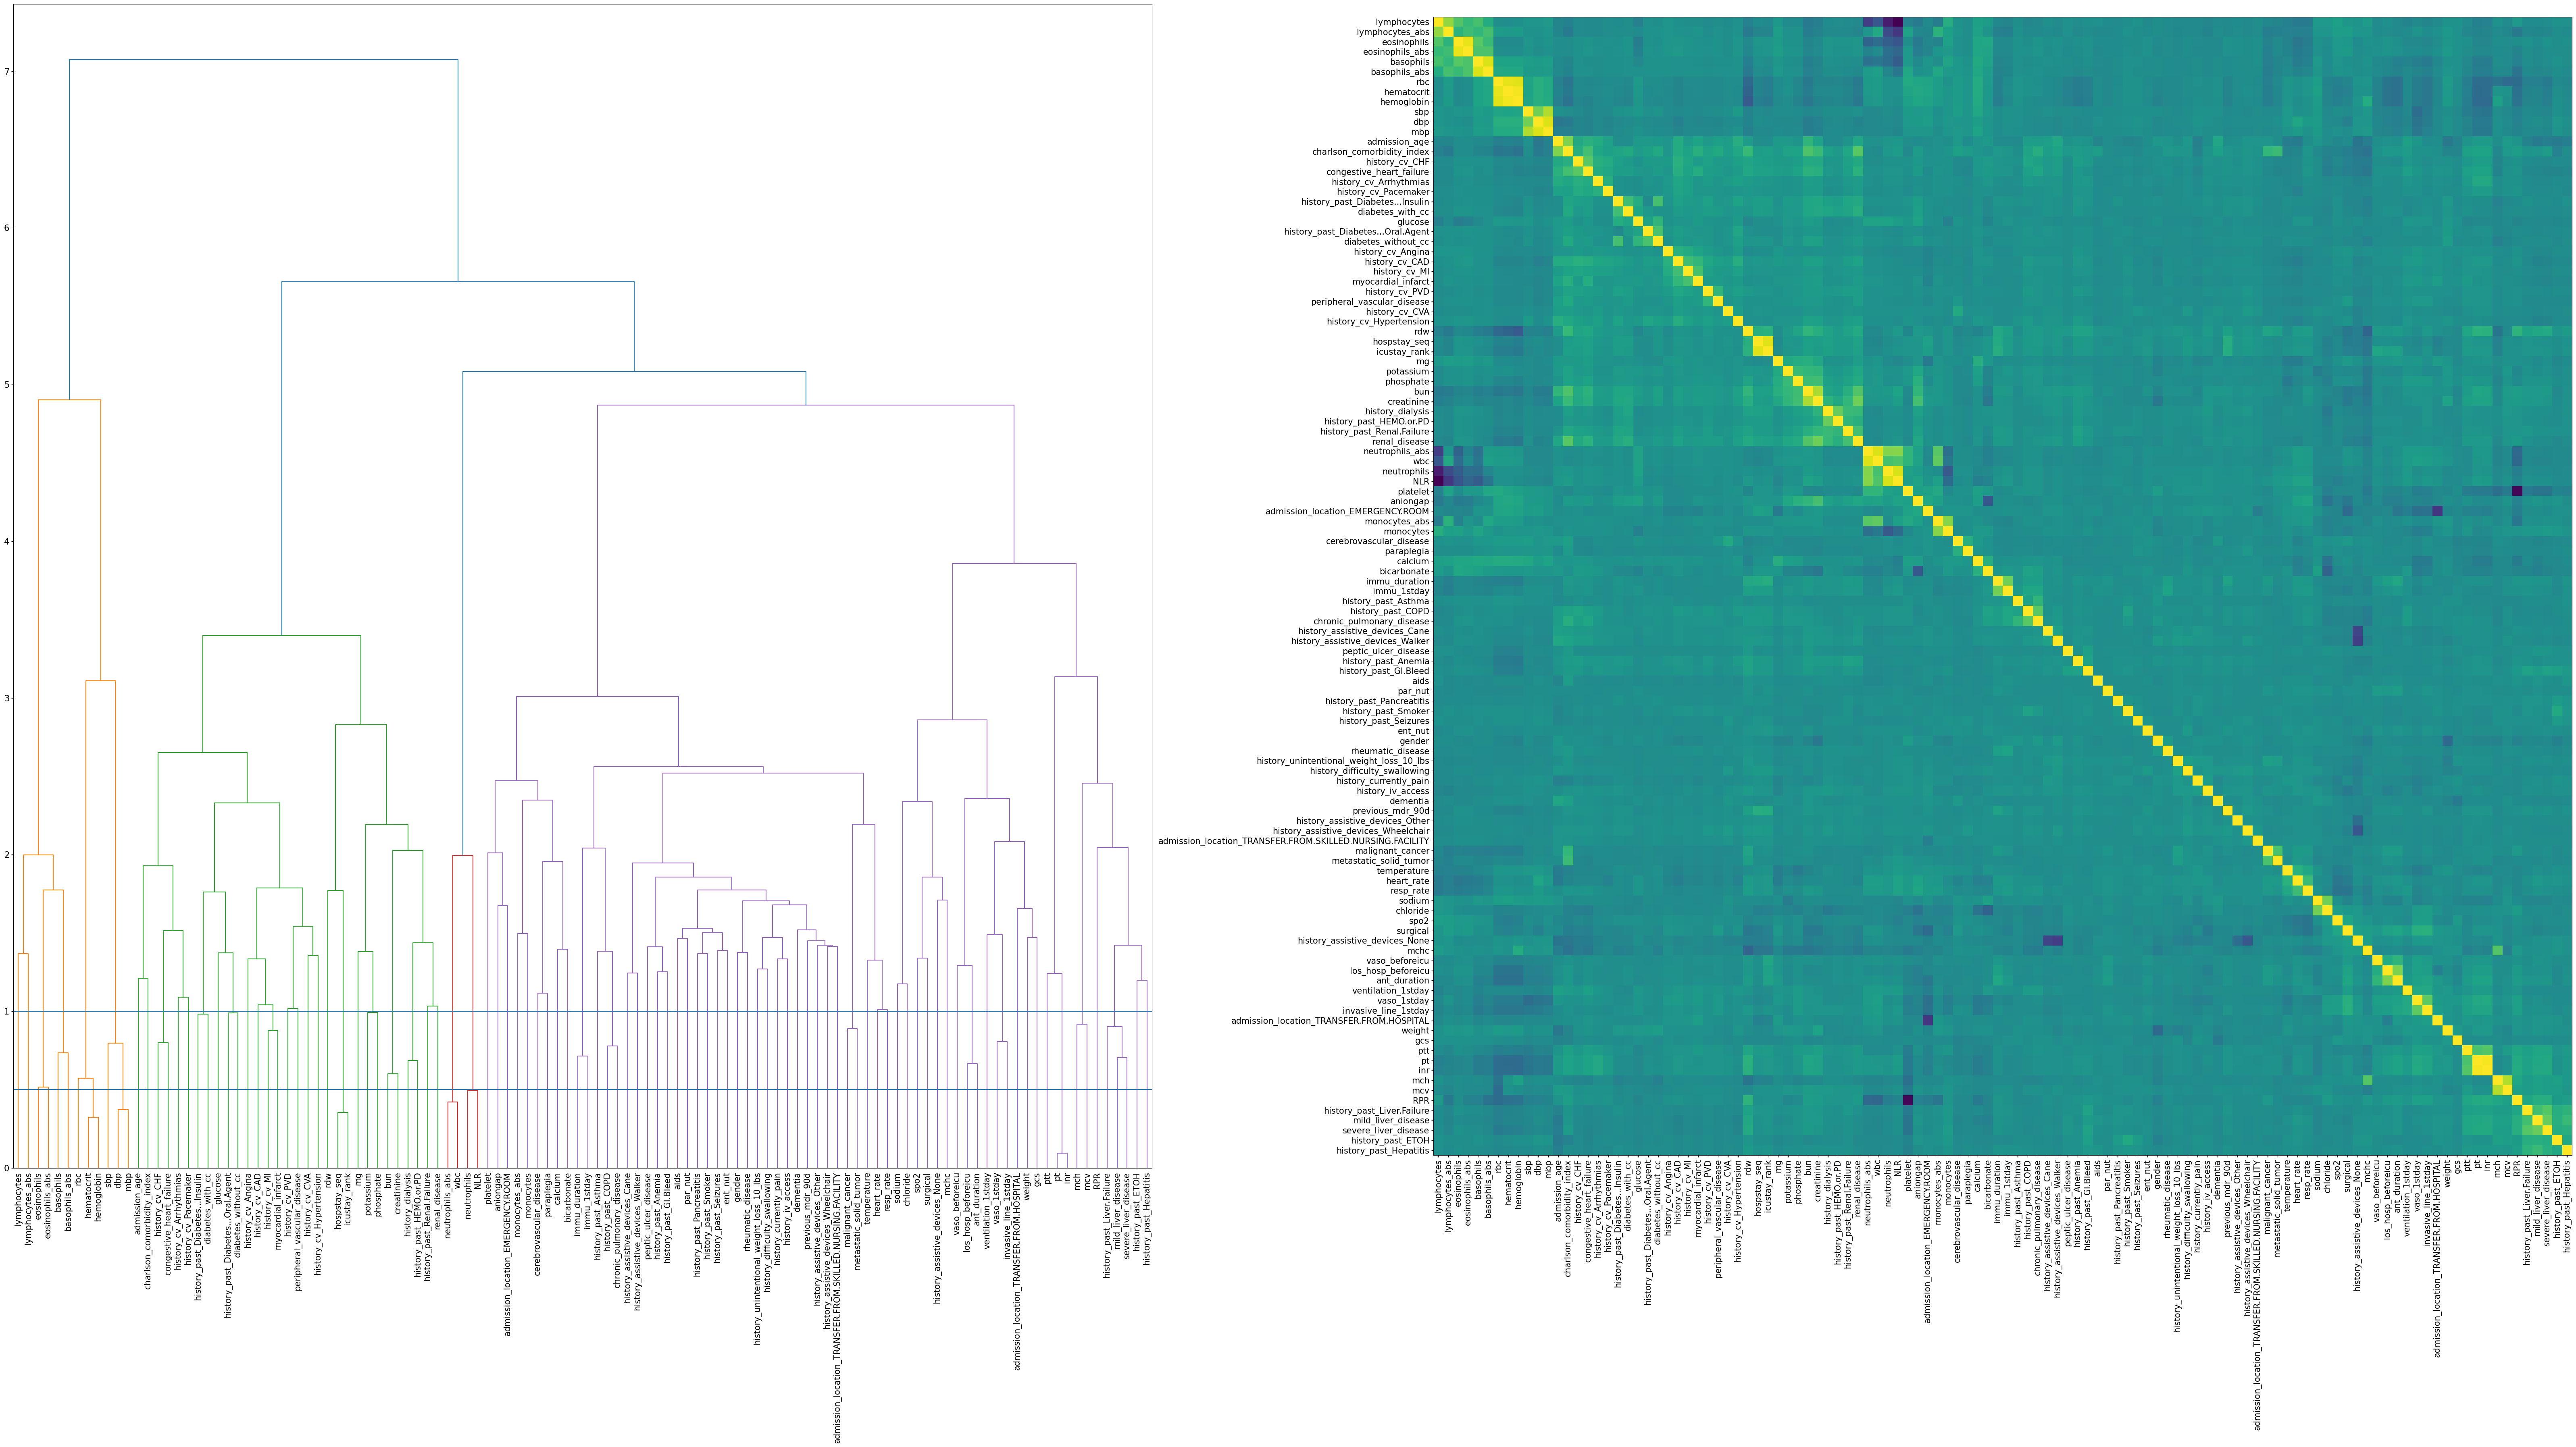

In [60]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(64, 36))
corr = spearmanr(x_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=features_tot, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax1.axhline(1)
ax1.axhline(0.5)
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
fig.tight_layout()
plt.show()

In [61]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features_col = [v[0] for v in cluster_id_to_feature_ids.values()]

In [62]:
selected_features_col = ['gender',
 'admission_age',
# 'ethnicity',
 'weight',
 'hospstay_seq',
 'icustay_rank',
 'los_hosp_beforeicu',
#####################                         
'previous_mdr_90d',
##########################
                         
                         
##############
'history_unintentional_weight_loss_10_lbs',
 'history_assistive_devices_Cane',
#  'history_assistive_devices_None',
#  'history_assistive_devices_Other',
 
 'history_assistive_devices_Walker',
 'history_assistive_devices_Wheelchair',
 'history_currently_pain',
 'history_dialysis',
 'history_difficulty_swallowing',
 'history_iv_access',
 'history_past_Anemia',
 'history_past_Asthma',
 'history_past_COPD',
 'history_past_Diabetes...Insulin',
 'history_past_Diabetes...Oral.Agent',
 'history_past_ETOH',
 'history_past_GI.Bleed',
 'history_past_HEMO.or.PD',
 'history_past_Hepatitis',
 'history_past_Liver.Failure',
 'history_past_Pancreatitis',
 'history_past_Renal.Failure',
 'history_past_Seizures',
 'history_past_Smoker',
 'history_cv_Angina',
 'history_cv_Arrhythmias',
 'history_cv_CAD',
 'history_cv_CHF',
 'history_cv_CVA',
 'history_cv_Hypertension',
 'history_cv_MI',
 'history_cv_PVD',
 'history_cv_Pacemaker', 
 #######################                       
 'calcium',
 'aniongap',
 'potassium',
 'bicarbonate',
 'glucose',
 'bun',
 'sodium',
 'chloride',
 'creatinine',
#  'pco2',
#  'po2',
# 'totalco2',
#  'baseexcess',
#  'ph',
# 'lactate',
# 'eosinophils',
 'monocytes_abs',
 'neutrophils_abs',
#  'basophils',
#  'monocytes',
#  'neutrophils',
 'eosinophils_abs',
 'basophils_abs',
# 'lymphocytes',
 'lymphocytes_abs',
# 'ptt',
# 'pt',
 'inr',
# 'hematocrit',
 'hemoglobin',
 'mch',
 'mchc',
 'mcv',
 'platelet',
# 'rbc',
 'rdw',
 'wbc',
 'heart_rate',
 'spo2',
 'sbp',
 'dbp',
# 'mbp',
 'resp_rate',
 'temperature',
                         
###############################
 # 'admission_location_EMERGENCY.ROOM',
 # 'admission_location_TRANSFER.FROM.HOSPITAL',
 # 'admission_location_TRANSFER.FROM.SKILLED.NURSING.FACILITY',
# 'admission_location_other',
################################
 'myocardial_infarct',
 'congestive_heart_failure',
 'peripheral_vascular_disease',
 'cerebrovascular_disease',
 'dementia',
 'chronic_pulmonary_disease',
 'rheumatic_disease',
 'peptic_ulcer_disease',
 'mild_liver_disease',
 'diabetes_without_cc',
 'diabetes_with_cc',
 'paraplegia',
 'renal_disease',
 'malignant_cancer',
 'severe_liver_disease',
 'metastatic_solid_tumor',
 'aids',
'charlson_comorbidity_index',
 'immu_duration',
 'ant_duration',
# 'ant_1stday',
#  'immu_1stday',
#  'vaso_beforeicu',
#  'vaso_1stday',
#  'surgical',
#  'invasive_line_1stday',
#  'ventilation_1stday',
#  'ent_nut',
#  'par_nut',
 'gcs',
#  'gcs_motor',
#  'gcs_eyes',
#  'gcs_verbal',
#  'gcs_unable',
#  'lods',
# 'sofa',
#  'sirs',
# 'apsiii',
#  'sapsii',
#  'oasis',
  'RPR',
 'NLR',
#'shock_index'
'mg', 'phosphate'
]

In [63]:
x_train_sel = x_train.loc[:, selected_features_col]
x_test_sel = x_test.loc[:, selected_features_col]

clf_sel = RandomForestClassifier(random_state=2021,min_samples_split=10,max_depth = 5, n_estimators=50, n_jobs = -1)
clf_sel.fit(x_train_sel, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=50,
                       n_jobs=-1, random_state=2021)

In [64]:
predict_train_sel = clf_sel.predict_proba(x_train_sel)
predict_test_sel = clf_sel.predict_proba(x_test_sel)

In [65]:
roc_auc_score(y_train, predict_train_sel[:,1]),\
roc_auc_score(y_test, predict_test_sel[:,1])

(0.7620618017422878, 0.7164206793350142)

In [66]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf_sel, x_train_sel,y_train,scoring = 'roc_auc', n_repeats= 30, random_state=2021, n_jobs = -1)

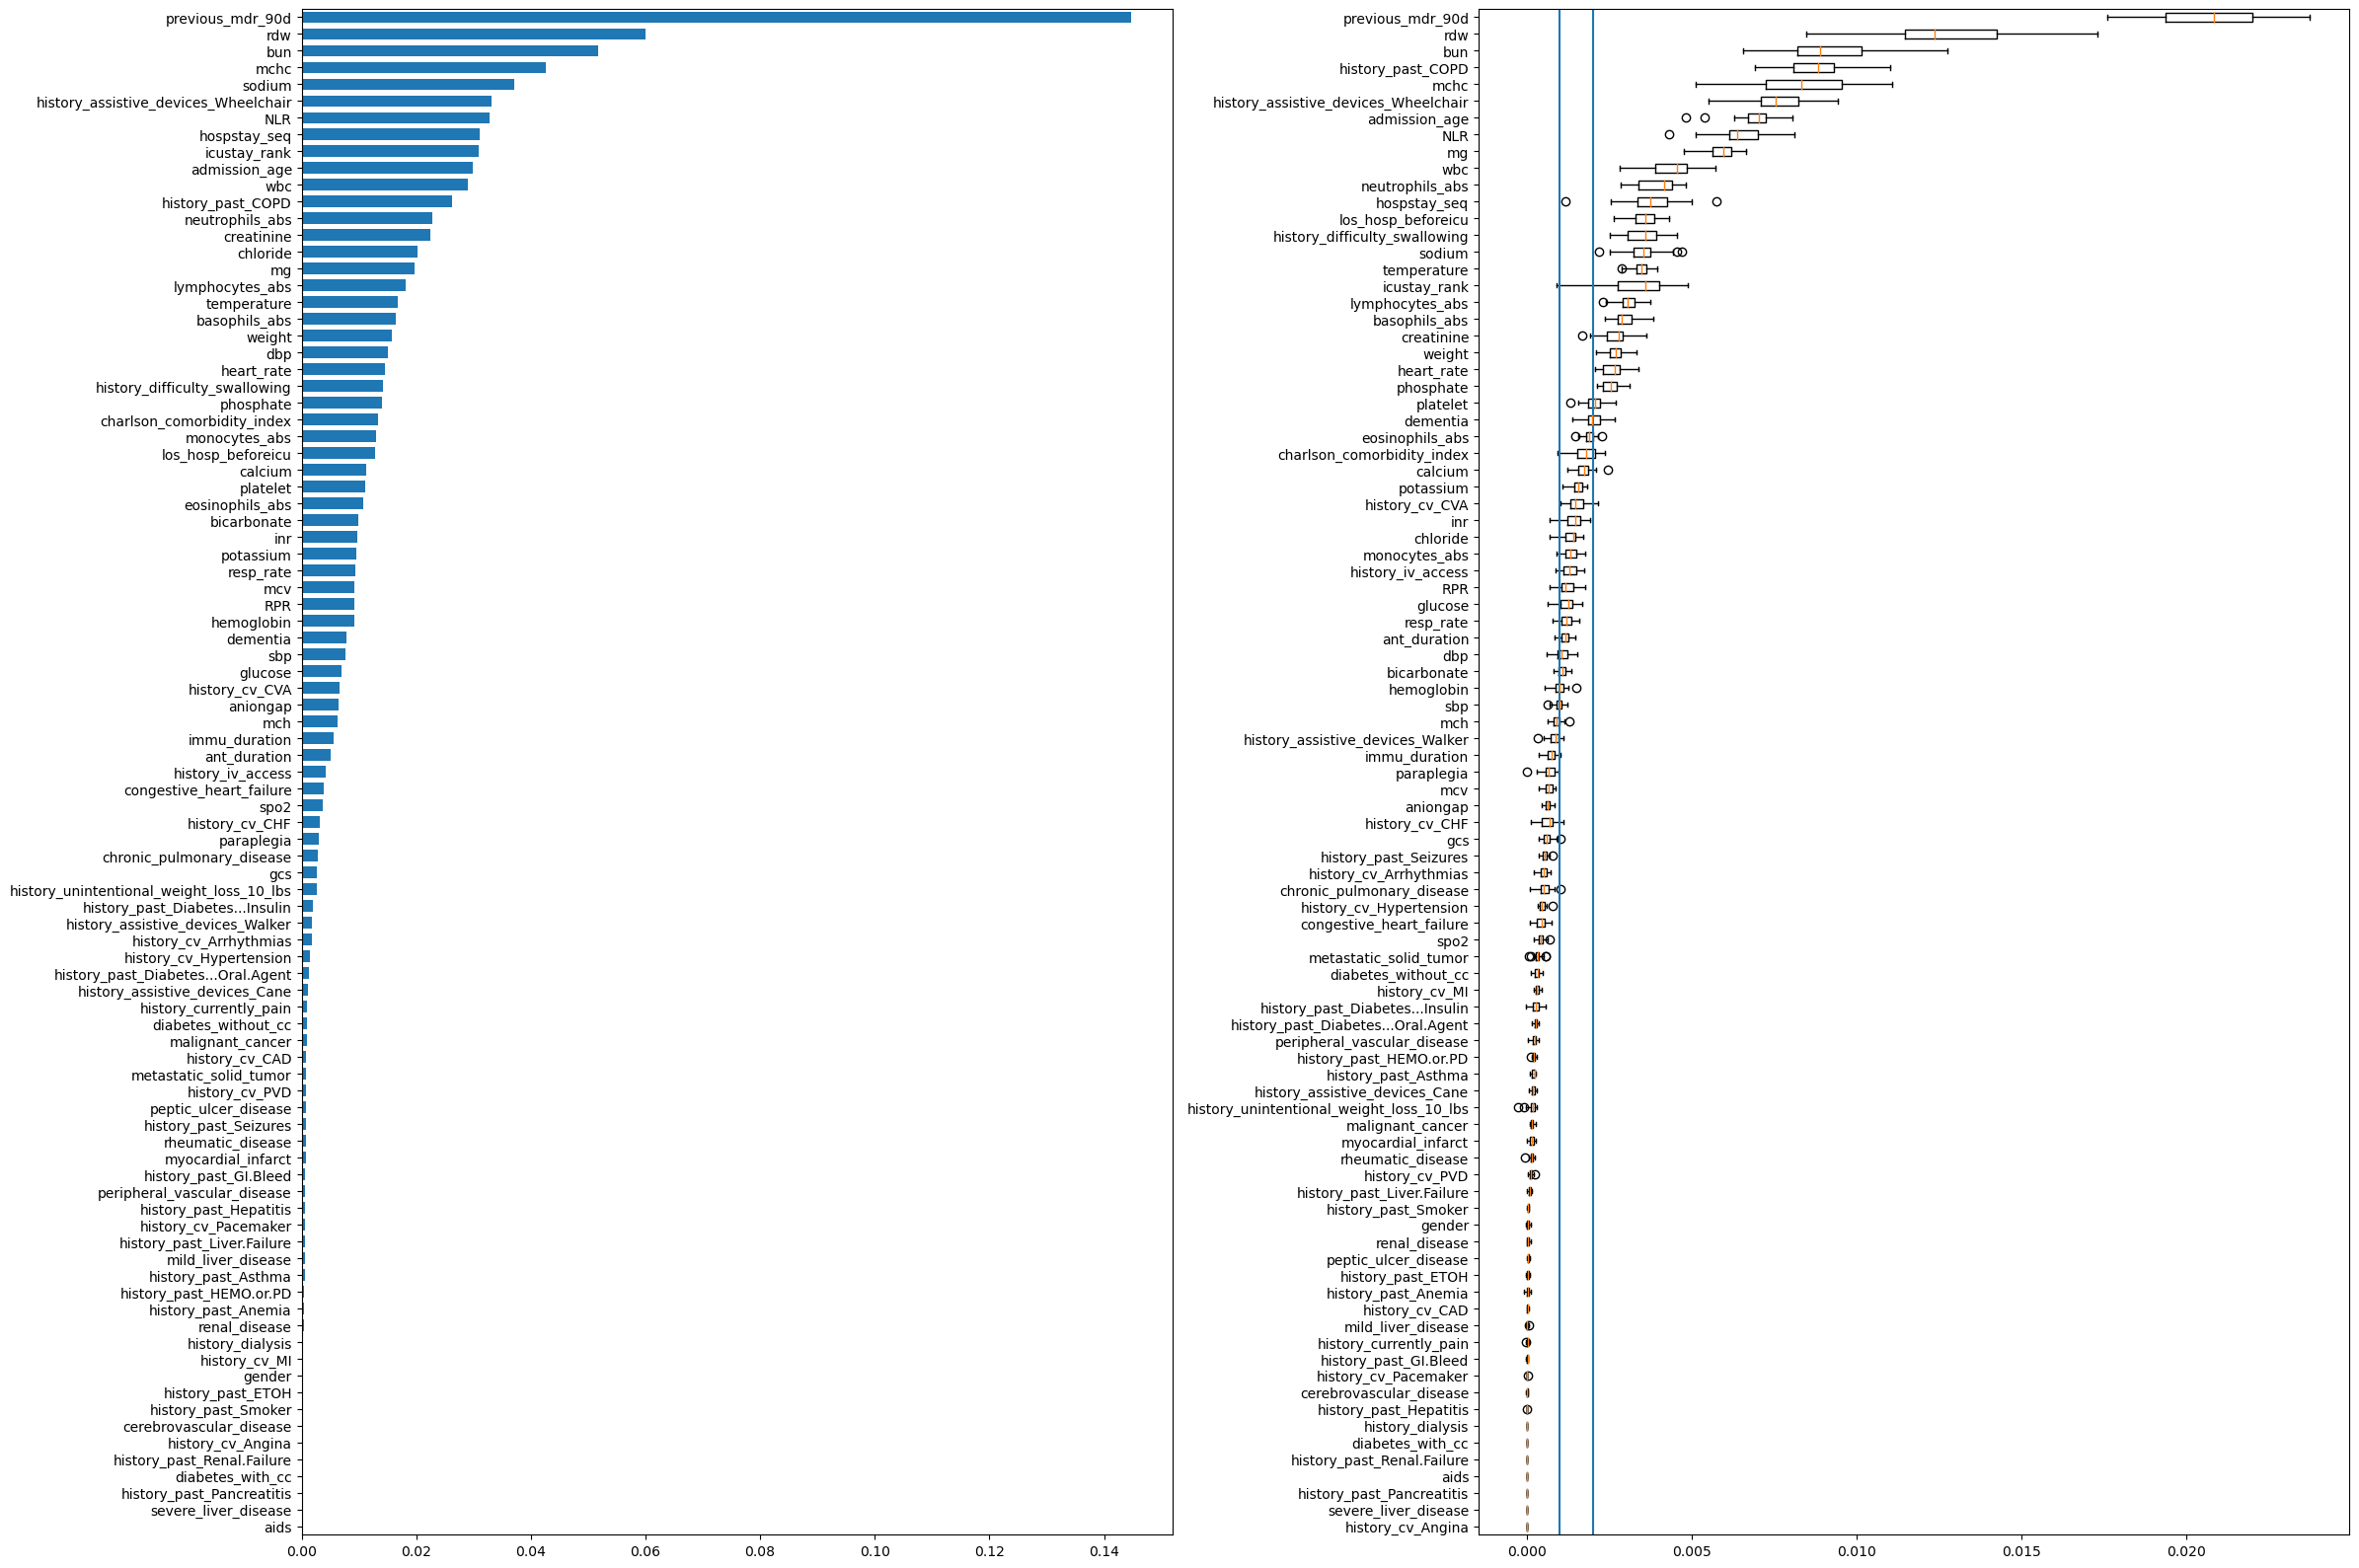

In [67]:
perm_sorted_idx = r.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(x_train_sel.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=x_train_sel.columns[perm_sorted_idx])
ax2.axvline(0.001)
ax2.axvline(0.002)
fig.tight_layout()
plt.show()

In [68]:
features = x_train_sel.columns[r.importances_mean>0.002].to_list()

In [69]:
features = x_train_sel.columns[perm_sorted_idx][-25:].to_list()

In [70]:
#features = x_train_sel.columns[tree_importance_sorted_idx][-20:].to_list()

In [71]:
features

['dementia',
 'platelet',
 'phosphate',
 'heart_rate',
 'weight',
 'creatinine',
 'basophils_abs',
 'lymphocytes_abs',
 'icustay_rank',
 'temperature',
 'sodium',
 'history_difficulty_swallowing',
 'los_hosp_beforeicu',
 'hospstay_seq',
 'neutrophils_abs',
 'wbc',
 'mg',
 'NLR',
 'admission_age',
 'history_assistive_devices_Wheelchair',
 'mchc',
 'history_past_COPD',
 'bun',
 'rdw',
 'previous_mdr_90d']

In [72]:
x_val = val_df[features]
y_val = val_df[['stay_chart_included_mdr']]

In [73]:
x_train_f = x_train[features]
x_test_f = x_test[features]

clf_f = RandomForestClassifier(random_state=2021,min_samples_split=10,max_depth = 5, n_estimators=50, n_jobs = -1)
clf_f.fit(x_train_f, y_train)

predict_train_f = clf_f.predict_proba(x_train_f)
predict_test_f = clf_f.predict_proba(x_test_f)
predict_val_f = clf_f.predict_proba(x_val)

roc_auc_score(y_val, predict_val_f[:,1])

0.7382365008237655

In [74]:
roc_auc_score(y_test, predict_test_f[:,1])

0.7121110325318246

###### 